# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- homework_modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [52]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [95]:
# (re-)load layers
%run homework_modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

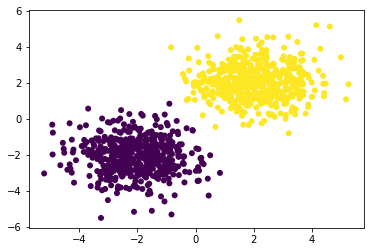

In [33]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [34]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())
# print(net)

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [35]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [36]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

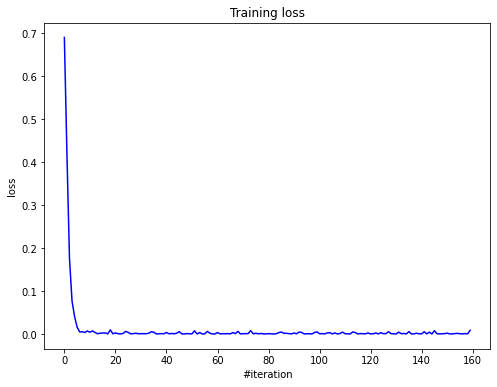

Current loss: 0.008583


In [37]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [38]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [55]:
# Your code goes here. ################################################
def one_hot(labels):
    return np.eye(10)[labels.reshape(-1)]

one_hot_y_train = one_hot(y_train)
one_hot_y_val = one_hot(y_val)
one_hot_y_test = one_hot(y_test)

X_train = X_train.reshape([len(X_train),-1])
X_val = X_val.reshape([len(X_val),-1])
X_test = X_test.reshape([len(X_test),-1])

def accuracy(prediction, label):
    pred = np.argmax(prediction, axis = -1)
    return 1 - len(np.nonzero(label-pred)[0])/len(label)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [116]:
# Your code goes here. ################################################
acts = ["relu", "elu", "leaky_relu", "soft_plus"]
opts = ["momentum", "adam"]
def net(act="relu", bnorm=False, opt="adam", alpha=0.9, drop=False):
    net = Sequential()
    net.add(Linear(28*28, 200))
    
    if bnorm:
        torch_layer = torch.nn.BatchNorm1d(200, eps=BatchNormalization(alpha).EPS, momentum=1.-alpha, affine=False)
        bn = BatchNormalization(alpha)
        bn.moving_mean = torch_layer.running_mean.numpy().copy()
        bn.moving_variance = torch_layer.running_var.numpy().copy()
        net.add(bn)
        net.add(ChannelwiseScaling(200))
    
    if drop:
        net.add(Dropout(0.9))
    
    if act == "relu":
        net.add(ReLU())
    elif act == "elu":
        net.add(ELU())
    elif act == "leaky_relu":
        net.add(LeakyReLU())
    elif act == "soft_plus":
        net.add(SoftPlus())
    
    net.add(Linear(200,10))
    
    if bnorm:
        torch_layer = torch.nn.BatchNorm1d(10, eps=BatchNormalization(alpha).EPS, momentum=1.-alpha, affine=False)
        bn = BatchNormalization(alpha)
        bn.moving_mean = torch_layer.running_mean.numpy().copy()
        bn.moving_variance = torch_layer.running_var.numpy().copy()
        net.add(bn)
        net.add(ChannelwiseScaling(10))
    
    net.add(LogSoftMax())
    criterion = ClassNLLCriterion()

    n_epoch = 30
    batch_size = 1000
    optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
    optimizer_state = {}

    t = 0
    val_acc = []
    val_loss = []
    train_acc = []
    train_loss = []
    test_acc = []
    test_loss = []
    
    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X_train, one_hot_y_train), batch_size):
            net.zeroGradParameters()
            time_start = time()
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            if opt == "momentum":
                sgd_momentum(net.getParameters(), 
                             net.getGradParameters(), 
                             optimizer_config,
                             optimizer_state)
            elif opt == "adam":
                adam_optimizer(net.getParameters(), net.getGradParameters(), {'learning_rate': 1e-2, 'beta1':0.9, 'beta2':0.99, 'epsilon': 1e-8}, {})
            time_finish = time()
            t += (time_finish - time_start) 

        pred_train = net.forward(X_train)
        train_loss.append(criterion.forward(pred_train, one_hot_y_train))
        train_acc.append(accuracy(pred_train, np.argmax(one_hot_y_train, axis=-1)))
        pred_val = net.forward(X_val)
        val_loss.append(criterion.forward(pred_val, one_hot_y_val))
        val_acc.append(accuracy(pred_val, np.argmax(one_hot_y_val, axis=-1)))
        pred_test = net.forward(X_test)
        test_loss.append(criterion.forward(pred_test, one_hot_y_test))
        test_acc.append(accuracy(pred_test, np.argmax(one_hot_y_test, axis=-1)))
        
    return net, train_loss, train_acc, val_loss, val_acc, test_loss, test_acc, t

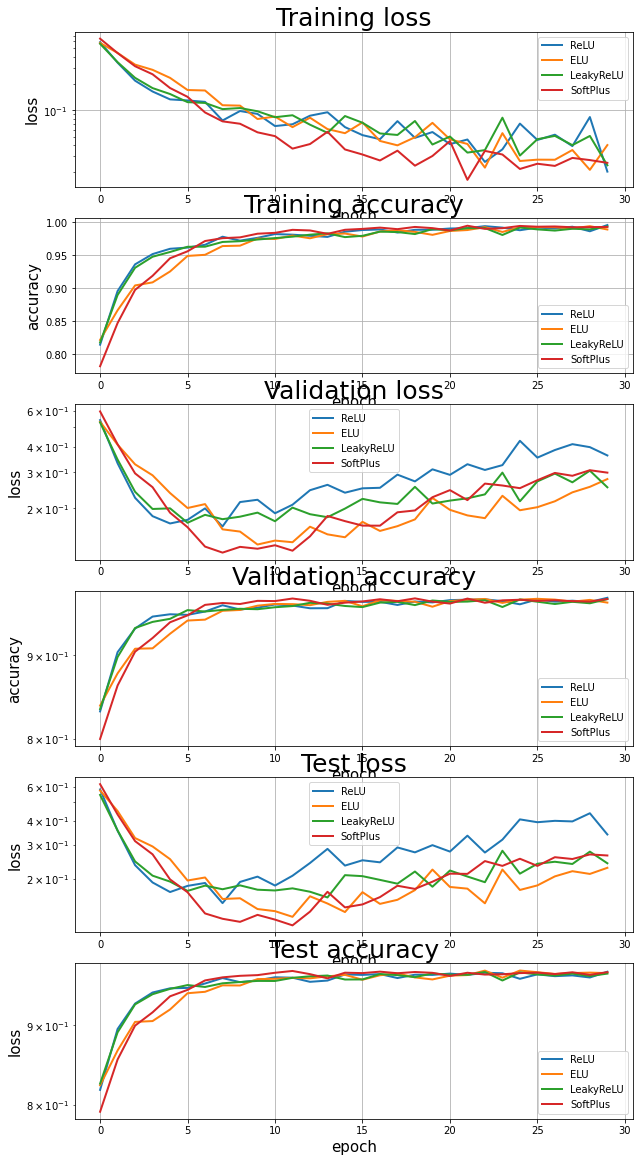

Resulting duration of training: 
 for ReLU: 111.08510828018188, 
 for ELU: 116.9080023765564 s, 
 for LeakyReLU: 108.05700063705444 s, 
 for SoftPlus: 107.3961021900177


In [117]:
net_relu, train_loss_relu, train_acc_relu, val_loss_relu, val_acc_relu, test_loss_relu, test_acc_relu, time_relu = net()
net_elu, train_loss_elu, train_acc_elu, val_loss_elu, val_acc_elu, test_loss_elu, test_acc_elu, time_elu = net(act="elu")
net_leakrelu, train_loss_leakrelu, train_acc_leakrelu, val_loss_leakrelu, val_acc_leakrelu, test_loss_leakrelu, test_acc_leakrelu, time_leakrelu = net(act="leaky_relu")
net_soft, train_loss_soft, train_acc_soft, val_loss_soft, val_acc_soft, test_loss_soft, test_acc_soft, time_soft = net(act="soft_plus")

plt.figure(figsize=(10, 20))

plt.subplot(6,1,1)
plt.title("Training loss", fontsize = 25)
plt.xlabel("epoch", fontsize = 15)
plt.ylabel("loss", fontsize = 15)
plt.semilogy(train_loss_relu, lw = 2, label = 'ReLU')
plt.semilogy(train_loss_elu, lw = 2, label = 'ELU')
plt.semilogy(train_loss_leakrelu, lw = 2, label = 'LeakyReLU')
plt.semilogy(train_loss_soft, lw = 2, label = 'SoftPlus')
plt.grid(True)
plt.legend()

plt.subplot(6,1,2)
plt.title("Training accuracy", fontsize = 25)
plt.xlabel("epoch", fontsize = 15)
plt.ylabel("accuracy", fontsize = 15)
plt.plot(train_acc_relu, lw = 2, label = 'ReLU')
plt.plot(train_acc_elu, lw = 2, label = 'ELU')
plt.plot(train_acc_leakrelu, lw = 2, label = 'LeakyReLU')
plt.plot(train_acc_soft, lw = 2, label = 'SoftPlus')    
plt.grid(True)
plt.legend()

plt.subplot(6,1,3)
plt.title("Validation loss", fontsize = 25)
plt.xlabel("epoch", fontsize = 15)
plt.ylabel("loss", fontsize = 15)
plt.semilogy(val_loss_relu, lw = 2, label = 'ReLU')
plt.semilogy(val_loss_elu, lw = 2, label = 'ELU')
plt.semilogy(val_loss_leakrelu, lw = 2, label = 'LeakyReLU')
plt.semilogy(val_loss_soft, lw = 2, label = 'SoftPlus')
plt.grid(True)
plt.legend()

plt.subplot(6,1,4)
plt.title("Validation accuracy", fontsize = 25)
plt.xlabel("epoch", fontsize = 15)
plt.ylabel("accuracy", fontsize = 15)
plt.semilogy(val_acc_relu, lw = 2, label = 'ReLU')
plt.semilogy(val_acc_elu, lw = 2, label = 'ELU')
plt.semilogy(val_acc_leakrelu, lw = 2, label = 'LeakyReLU')
plt.semilogy(val_acc_soft, lw = 2, label = 'SoftPlus') 
plt.grid(True)
plt.legend()


plt.subplot(6,1,5)
plt.title("Test loss", fontsize = 25)
plt.xlabel("epoch", fontsize = 15)
plt.ylabel("loss", fontsize = 15)
plt.semilogy(test_loss_relu, lw = 2, label = 'ReLU')
plt.semilogy(test_loss_elu, lw = 2, label = 'ELU')
plt.semilogy(test_loss_leakrelu, lw = 2, label = 'LeakyReLU')
plt.semilogy(test_loss_soft, lw = 2, label = 'SoftPlus')
plt.grid(True)
plt.legend()

plt.subplot(6,1,6)
plt.title("Test accuracy", fontsize = 25)
plt.xlabel("epoch", fontsize = 15)
plt.ylabel("loss", fontsize = 15)
plt.semilogy(test_acc_relu, lw = 2, label = 'ReLU')
plt.semilogy(test_acc_elu, lw = 2, label = 'ELU')
plt.semilogy(test_acc_leakrelu, lw = 2, label = 'LeakyReLU')
plt.semilogy(test_acc_soft, lw = 2, label = 'SoftPlus') 
plt.grid(True)
plt.legend()

plt.show()
print(f'Resulting duration of training: \n for ReLU: {time_relu}, \n for ELU: {time_elu} s, \n for LeakyReLU: {time_leakrelu} s, \n for SoftPlus: {time_soft}')


In [118]:
import torch

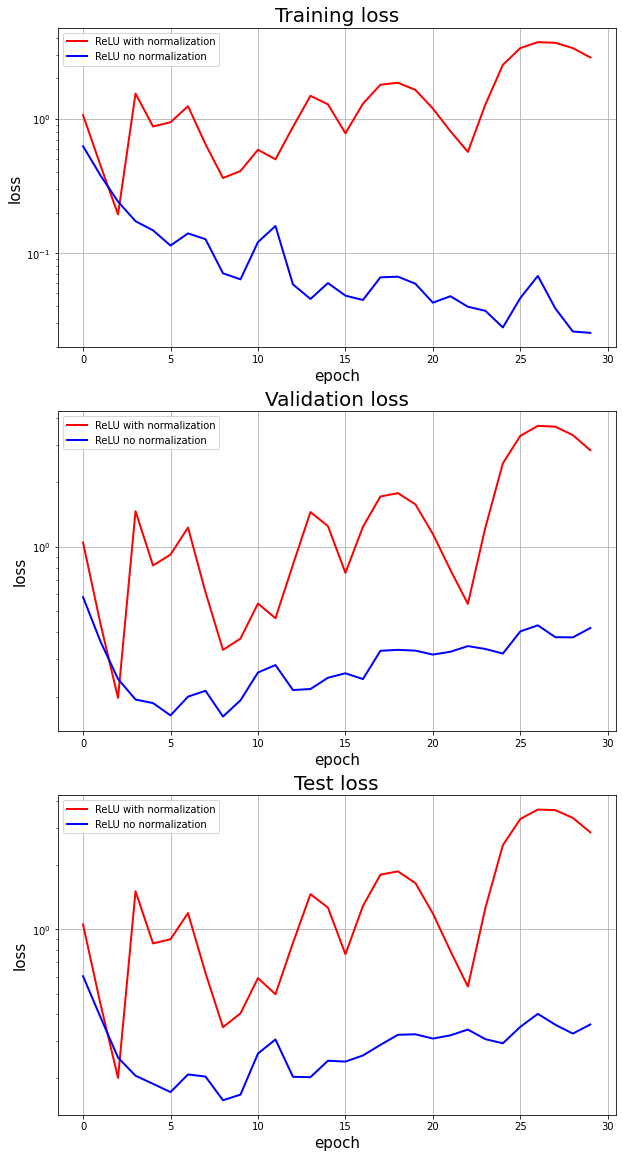

Resulting duration of training: 
 for ReLU without normalization: 105.05563569068909, 
 for ReLU with normalization: 109.18705487251282 


In [119]:
# Your answer goes here. ################################################
net_bn, train_loss_bn, train_acc_bn, val_loss_bn, val_acc_bn, test_loss_bn, test_acc_bn, time_bn = net(bnorm=True)
net_, train_loss, train_acc, val_loss, val_acc, test_loss, test_acc, time_ = net()
plt.figure(figsize=(10, 20))

plt.subplot(3,1,1)
plt.title("Training loss", fontsize = 20)
plt.xlabel("epoch", fontsize = 15)
plt.ylabel("loss", fontsize = 15)
plt.semilogy(train_loss_bn, lw = 2, color = 'r', label = 'ReLU with normalization')
plt.semilogy(train_loss, lw = 2, color ='b', label = 'ReLU no normalization')
plt.grid(True)
plt.legend()

plt.subplot(3,1,2)
plt.title("Validation loss", fontsize = 20)
plt.xlabel("epoch", fontsize = 15)
plt.ylabel("loss", fontsize = 15)
plt.semilogy(val_loss_bn, lw = 2, color ='r', label = 'ReLU with normalization')
plt.semilogy(val_loss, lw = 2, color ='b', label = 'ReLU no normalization')
plt.grid(True)
plt.legend()

plt.subplot(3,1,3)
plt.title("Test loss", fontsize = 20)
plt.xlabel("epoch", fontsize = 15)
plt.ylabel("loss", fontsize = 15)
plt.semilogy(test_loss_bn, lw = 2, color='r', label = 'ReLU with normalization')
plt.semilogy(test_loss, lw = 2, color='b', label = 'ReLU no normalization')
plt.grid(True)
plt.legend()

plt.show()
        
print(f'Resulting duration of training: \n for ReLU without normalization: {time_}, \n for ReLU with normalization: {time_bn} ')

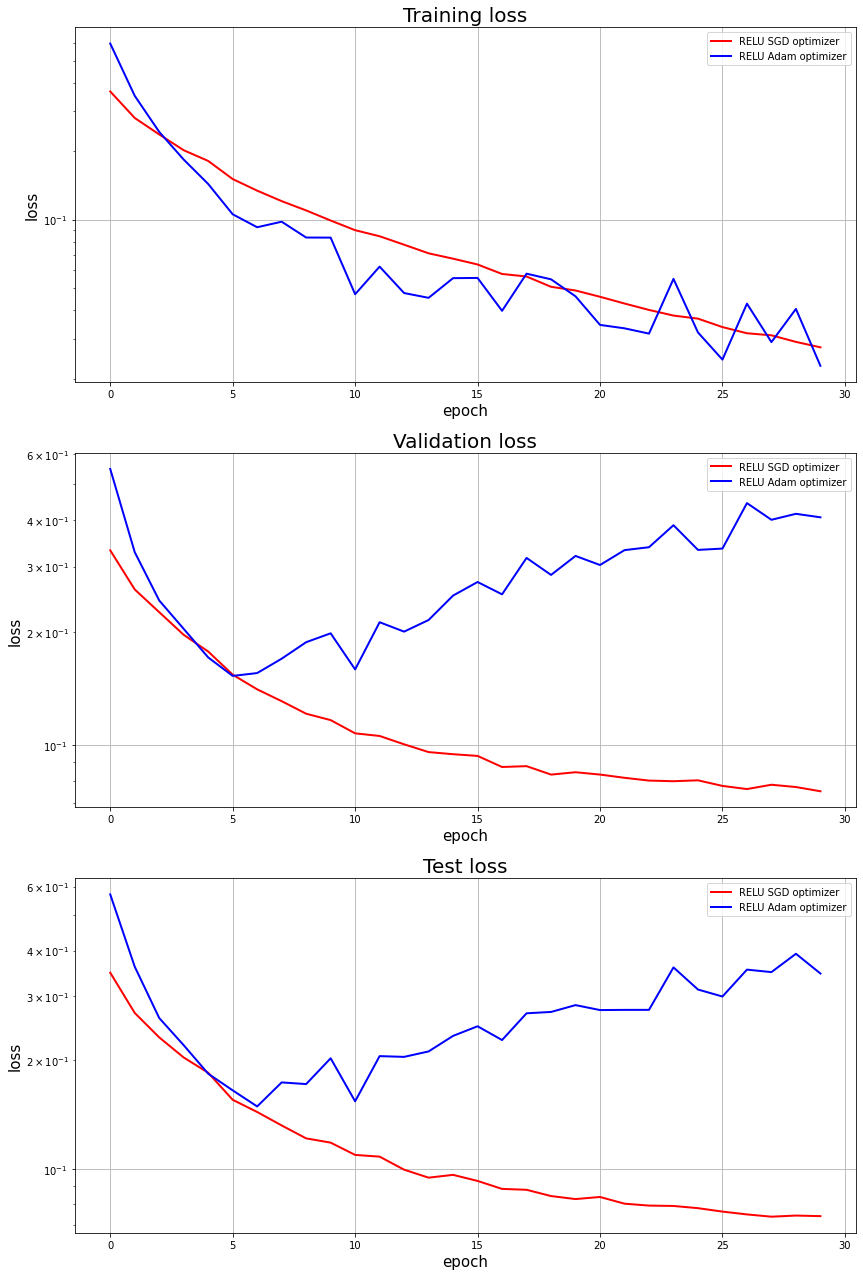

Resulting duration of training: 
 for RELU SGD optimizer: 101.45104050636292, 
 for RELU Adam optimizer: 103.04364466667175


In [120]:
net_mom, train_loss_mom, train_acc_mom, val_loss_mom, val_acc_mom, test_loss_mom, test_acc_mom, time_mom = net(opt="momentum")
net_adam, train_loss_adam, train_acc_adam, val_loss_adam, val_acc_adam, test_loss_adam, test_acc_adam, time_adam = net(opt="adam")

plt.figure(figsize=(14, 30))

plt.subplot(4,1,1)
plt.title("Training loss", fontsize = 20)
plt.xlabel("epoch", fontsize = 15)
plt.ylabel("loss", fontsize = 15)
plt.semilogy(train_loss_mom, lw = 2, color='r', label = 'RELU SGD optimizer')
plt.semilogy(train_loss_adam, lw = 2, color='b', label = 'RELU Adam optimizer')
plt.grid(True)
plt.legend()

plt.subplot(4,1,2)
plt.title("Validation loss", fontsize = 20)
plt.xlabel("epoch", fontsize = 15)
plt.ylabel("loss", fontsize = 15)
plt.semilogy(val_loss_mom, lw = 2, color='r', label = 'RELU SGD optimizer')
plt.semilogy(val_loss_adam, lw = 2, color='b', label = 'RELU Adam optimizer')
plt.grid(True)
plt.legend()

plt.subplot(4,1,3)
plt.title("Test loss", fontsize = 20)
plt.xlabel("epoch", fontsize = 15)
plt.ylabel("loss", fontsize = 15)
plt.semilogy(test_loss_mom, lw = 2, color='r', label = 'RELU SGD optimizer')
plt.semilogy(test_loss_adam, lw = 2, color='b', label = 'RELU Adam optimizer')
plt.grid(True)
plt.legend()

plt.show()

print(f'Resulting duration of training: \n for RELU SGD optimizer: {time_mom}, \n for RELU Adam optimizer: {time_adam}')

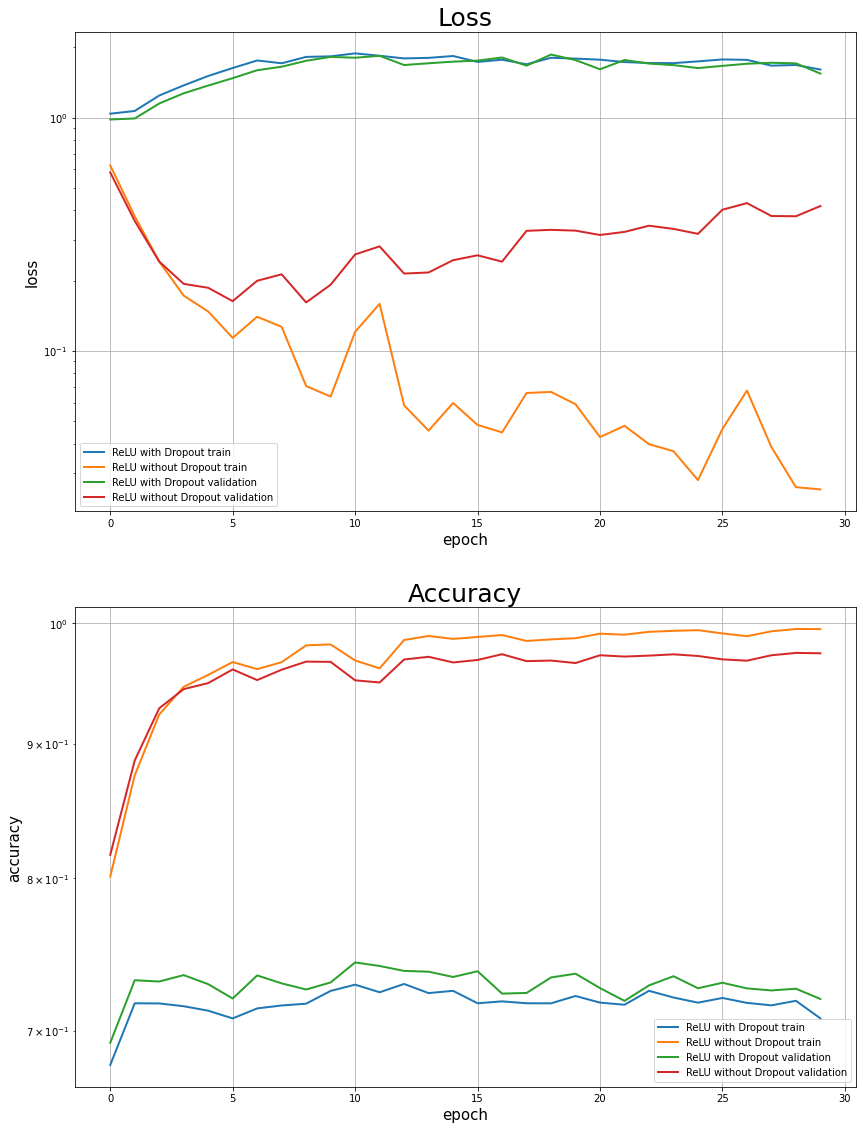

Resulting duration of training: 
 for Net with dropout optimizer: 116.85055375099182, 
 for net without dropout: 105.05563569068909


In [121]:
net_drop, train_loss_drop, train_acc_drop, val_loss_drop, val_acc_drop, test_loss_drop, test_acc_drop, time_drop = net(drop=True)

plt.figure(figsize=(14, 30))

plt.subplot(3,1,1)
plt.title("Loss", fontsize = 25)
plt.xlabel("epoch", fontsize = 15)
plt.ylabel("loss", fontsize = 15)
plt.semilogy(train_loss_drop, lw = 2, label = 'ReLU with Dropout train')
plt.semilogy(train_loss, lw = 2, label = 'ReLU without Dropout train')
plt.semilogy(val_loss_drop, lw = 2, label = 'ReLU with Dropout validation')
plt.semilogy(val_loss, lw = 2, label = 'ReLU without Dropout validation')
plt.grid(True)
plt.legend()


plt.subplot(3,1,2)
plt.title("Accuracy", fontsize = 25)
plt.xlabel("epoch", fontsize = 15)
plt.ylabel("accuracy", fontsize = 15)
plt.semilogy(train_acc_drop, lw = 2, label = 'ReLU with Dropout train')
plt.semilogy(train_acc, lw = 2, label = 'ReLU without Dropout train')
plt.semilogy(val_acc_drop, lw = 2, label = 'ReLU with Dropout validation')
plt.semilogy(val_acc, lw = 2, label = 'ReLU without Dropout validation')
plt.grid(True)
plt.legend()

plt.show()

print(f'Resulting duration of training: \n for Net with dropout optimizer: {time_drop}, \n for net without dropout: {time_}')


Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?